This notebook is a continuation of the `fim_matching_IEEE39.ipynb`.
Here, we want to only look at some area in the network.
The information about the area is obtained from [matpower](https://matpower.org/docs/ref/matpower5.0/menu5.0.html), which references Cornell's [TC calculator](https://www.pserc.cornell.edu/tcc/tcc.md-SYSTEM=2.html).
The buses in the area are buses 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 31, 32, and 39.

In [1]:
from pathlib import Path
import json
import random

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from information_matching.convex_optimization import ConvexOpt
from information_matching.utils import tol, eps

random.seed(1)
%matplotlib inline
plt.style.use("default")

In [2]:
# Set directories
case = 39  # 39-bus case

WORK_DIR = Path().absolute()
FIM_DIR = WORK_DIR / "FIMs"
DATA_DIR = WORK_DIR / "models" / "data"

# Setup

First, remember that we only want to make measurement of the buses in the area and we only care about the observability of these buses.

In [3]:
# Load the area data, which contains information about which buses in the area
with open(DATA_DIR / "area_partition.json", "r") as f:
    area_dict = json.load(f)

area = "Area1"
buses_area = area_dict[area]

In [4]:
# Model information
nparams = 2 * case

In [5]:
# Configurations
nconfigs = len(buses_area)
configs = buses_area
config_ids = np.array([f"bus{ii}" for ii in configs])
config_ids

array(['bus4', 'bus5', 'bus6', 'bus7', 'bus8', 'bus9', 'bus10', 'bus11',
       'bus12', 'bus13', 'bus14', 'bus31', 'bus32', 'bus39'], dtype='<U5')

In [6]:
# Load configuration FIMs
# Note that each candidate bus still measure the voltage phasor for all connected
# buses, even outside the area of interest.
fim_configs_tensor = np.empty((nconfigs, nparams, nparams))
for ii, bus in enumerate(configs):
    J = np.load(FIM_DIR / f"jacobian_bus{bus}.npy")
    I = J.T @ J
    fim_configs_tensor[ii] = I
# Scaling factor to help the convex optimization
norm = max(np.linalg.norm(fim_configs_tensor, axis=(1, 2)))
fim_configs_tensor[0].shape

(78, 78)

In [7]:
# Target FIM
# Index of the parameters for observation within the area
idx_buses = np.array(buses_area) - 1  # buses zero-based index
idx_params = np.sort(np.append(2 * idx_buses, 2 * idx_buses + 1))

lambda_tol = 1e-5  # Eigenvalue cutoff
fim_target = np.diag(np.zeros(nparams))
fim_target[idx_params, idx_params] = np.ones_like(idx_params) * lambda_tol
print("Eigenvalue lower bound:", lambda_tol)

Eigenvalue lower bound: 1e-05


# Convex optimization

Additional note:

We will perform the optimization iteratively.
In each iteration, we scale the weights being optimize by the optimal weights from the previous iteration.
By doing so, the objective function in the convex optimization better mimics $\ell_0$-norm to enforce sparsity.

In [8]:
# Construct the input FIMs
# FIM target is fine, because we only apply scale 1.0
# FIM configs
fim_configs = {}
for ii, identifier in enumerate(config_ids):
    fim_configs.update(
        {identifier: {"fim": fim_configs_tensor[ii], "fim_scale": 1 / norm}}
    )

In [9]:
# Convex optimization
# Settings
cvx_tol = eps ** 0.75
solver = dict(
    verbose=False,
    warm_start=True,
    solver=cp.SDPA,
    epsilonStar=cvx_tol
)
print("Tolerance:", cvx_tol)

result_dict = {}
for trial in range(50):
    # Try several small initial guesses
    wopt = np.zeros(nconfigs)
    idx = random.sample(range(nconfigs), 5)
    wopt[idx] = 1.0
    
    # Iterative optimization to mimic l0-norm objective
    for ii in range(20):
        # Update the weight scales
        for jj, identifier in enumerate(config_ids):
            # Add weight scale information,aAdd some small number for numerical stability
            fim_configs[identifier].update({"weight_scale": 1 / (wopt[jj] + 1e-15)})
        cvxopt = ConvexOpt(fim_target, fim_configs, l1norm_obj=True)

        try:
            # Solve
            if ii == 0:
                cvxopt.wm.value = wopt.reshape((-1, 1))
            cvxopt.solve(solver=solver)
            result = cvxopt.result.copy()
            wopt = result["wm"]
            dual = result["dual_wm"]
            print("Violation:", cvxopt.constraints[1].violation())
        except Exception:
            cvxopt.result = result
            break

    result_dict.update({trial: result})

Tolerance: 1.8189894035458565e-12
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 8.74696758340026e-08


/home/byu.local/yonatank/.local/lib/python3.7/site-packages/cvxpy/problems/problem.py:1388: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 5.887183104682816e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.9383983600865924e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.2208477356132888e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.10403436969265e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.1842375317676936e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.1887335394061952e-08
Step length is too small.  :: line 19

Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.614612491191109e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.614062876516193e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.6138731345650674e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.613724075142467e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.613679255857492e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.6136189565042905e-08
Step length is too small.  :: line 198

Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 9.787547874644316e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.748166310839299e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.635039963514073e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.262416639604526e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.9711265256299582e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.752122394844103e-08
Step length is too small.  :: line 198 

Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 7.734033775963498e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 7.735341903565796e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 7.737768853055396e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 7.73578597761777e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 7.736616103840649e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 7.736999001624812e-08
Step length is too small.  :: line 198 in

Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.6425589759474578e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.795083354800358e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.8317093537077795e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.8412251852845172e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.844169209396708e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.8455616143667475e-08
Step length is too small.  :: line 1

Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 9.376248856212602e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 9.374158673488033e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 9.372630075316123e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 9.372043947193677e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 9.37167268423888e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 9.371783122191265e-08
Step length is too small.  :: line 198 in

Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.1663358960576657e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.187600686812248e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.1908682584962197e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.1923303397002927e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.1929592920520167e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.1930250158994247e-08
Step length is too small.  :: line 

Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.08574478177522e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.085924538673563e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.0856628081894616e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 3.085882978713524e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 9.013631562703137e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 4.248850765723645e-08
Step length is too small.  :: line 198 i

Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.1184604433469386e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.1301860955376286e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.136638181225237e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.1354419954404986e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.13363755028257e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.1327607587466015e-08
Step length is too small.  :: line 19

In [10]:
# Post-processing - Get the best result
obj_vals = np.array([val["value"] for val in result_dict.values()])
best_result = result_dict[np.argmin(obj_vals)]

wopt = best_result["wm"]
dual = best_result["dual_wm"]
value = best_result["value"]
print("Optimal objective value:", value)

Optimal objective value: 2.9999992471300585


## Post-processing

In [11]:
# # Plot the weights of the last step
# plt.figure()
# plt.title(f"Eigenvalue lower bound: {lambda_tol:0.3e}")
# plt.plot(wopt, label="weights")
# plt.plot(dual, label="dual weights")
# plt.yscale("log")
# plt.xticks(range(nconfigs), config_ids, rotation=90)
# plt.legend()
# plt.show()

In [12]:
# Get the optimal buses
idx_wopt = np.where(wopt > cvx_tol)[0]  # Index to the optimal bues
print("Optimal buses:")
_ = [print(f'{config_ids[ii]} \t {wopt[ii]}') for ii in idx_wopt]

Optimal buses:
bus6 	 0.05898049290181626
bus8 	 408.77550891777554
bus13 	 0.059926205444719174


Eigenvalues:
[-6.68733152e-09 -6.14440645e-09 -2.78398138e-09 -2.30952657e-09
 -1.17069645e-09 -9.32898739e-10 -7.68251196e-10 -3.75949150e-10
 -3.04559926e-10 -9.42937575e-11 -3.22217308e-25 -1.53807699e-25
 -6.25360531e-26 -3.98867739e-26 -1.41234072e-26  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.38963787e-58  1.73766473e-43  5.92468444e-42  4.05802802e-26
  1.04688155e-25  1.48702252e-25  1.57186846e-10  2.74108576e-10
  6.01424379e-10  6.49587532e-10  7.59909512e-10  9.99209766e-10
  1.29103112e-09  1.46868510e-09  1.97080508e-09  2.31115280e-09
  7.40048236e-09  3.12013888e-08  1.04853875e+01  1.07653759e+01
  2.82893936e+01  2.84028242e+01  3.59075665e+01  3.61507403e+01
  7.20540539e+01  7.31715561e+01  1.32608461e+02  1.33251417e+02
  6.69940159e+04  7.11033412e+04  4.75580138e+05  4.85283458e+05
  1.83195508e+06  1.98015554e+06  2.94814713e+06  3.07007871e+06
  3.33127282e+06  3.51097334e+06  1.58405145e+07  1.63686022e+07
  1.73141437

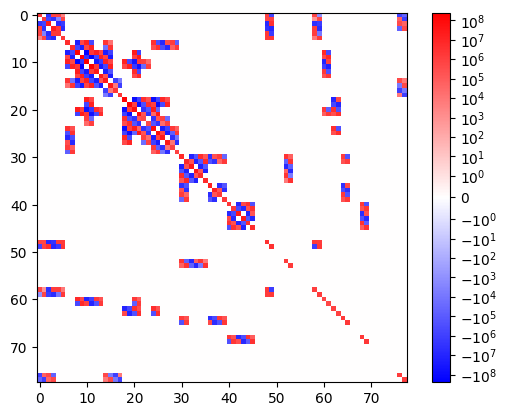

In [13]:
# Test the optimal buses
weighted_fims_configs = fim_configs_tensor * wopt.reshape((-1, 1, 1))
I = np.sum(weighted_fims_configs[idx_wopt], axis=0)
print("Eigenvalues:")
print(np.linalg.eigvalsh(I))

plt.figure()
cbound = np.max([abs(np.min(I)), abs(np.max(I))])
plt.imshow(I, cmap="bwr", norm=mpl.colors.SymLogNorm(1e0, vmin=-cbound, vmax=cbound))
plt.colorbar()
plt.show()